### 通し課題1 Kickstar Ploject

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_recall_fscore_support
import datetime
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf

In [15]:
df_ks0 = pd.read_csv("kickstarter-projects/ks-projects-201801.csv")
df_ks0.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [16]:
#必要そうな列だけcsv読み込む
df_ks = pd.read_csv("kickstarter-projects/ks-projects-201801.csv")[[ 'state', 'category', 'main_category', 'currency', 'goal', 'deadline', 'launched']]

#KSのlaunched、deadlineから開催期間(日数)を計算する
#文字列をdatetime型に変換
#df_ks['launched'] = datetime.datetime.strptime(df_ks['launched'], '%Y/%m/%d %H:%M') 
#df_ks['deadline'] = datetime.datetime.strptime(df_ks['deadline'], '%Y/%m/%d')
df_ks['launched'] = pd.to_datetime(df_ks['launched']) 
df_ks['deadline'] = pd.to_datetime(df_ks['deadline'])

#期間を計算
df_ks['delta'] = (df_ks['deadline'] - df_ks['launched']).apply(lambda x: x.days)
#こっちだとエラー出た
#df_ks['delta'] = datetime.datetime.strptime(df_ks['launched'], '%d %H:%M:%S')
#.apply(~がないとerror起こす。配列には適用できない？
#print(df_ks['delta'].days)

#launch, deadline削除
df_ks = df_ks.drop(columns=['launched', 'deadline'])
#stateがsuccessfulとfailed以外のもの削除
df_ks = df_ks.query('state == ["successful", "failed"]')

#stateの列を数字に置き換え(failedを0、successfulを1)
for df in [df_ks]:    
    df.loc[df['state']=='failed', "state"]=0
    df.loc[df['state']=='successful', "state"]=1

#データを表示
print(df_ks.head())
#欠損値がないか確認
print(df_ks.isnull().sum())
print(df_ks.notnull().sum())

   state        category main_category currency     goal  delta
0      0          Poetry    Publishing      GBP   1000.0     58
1      0  Narrative Film  Film & Video      USD  30000.0     59
2      0  Narrative Film  Film & Video      USD  45000.0     44
3      0           Music         Music      USD   5000.0     29
5      1     Restaurants          Food      USD  50000.0     34
state            0
category         0
main_category    0
currency         0
goal             0
delta            0
dtype: int64
state            331675
category         331675
main_category    331675
currency         331675
goal             331675
delta            331675
dtype: int64


   state        category main_category currency     goal  delta  goal_band
0      0          Poetry    Publishing      GBP   1000.0     58          0
1      0  Narrative Film  Film & Video      USD  30000.0     59          5
2      0  Narrative Film  Film & Video      USD  45000.0     44          5
3      0           Music         Music      USD   5000.0     29          1
5      1     Restaurants          Food      USD  50000.0     34          5


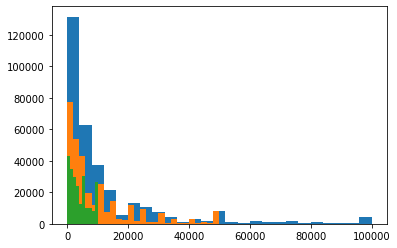

In [17]:
#とりあえず定量的な値はgoalとdeltaだけなのでこれらを使う。
#goalの分布
data = df_ks['goal']
plt.hist(data, range=(0, 100000), bins=25);
plt.hist(data, range=(0, 50000), bins=25);
plt.hist(data, range=(0, 10000), bins=10);

#goalを金額で7つに分類
for df in [df_ks]:
    df['goal_band'] = pd.cut(df.goal, [0, 2500, 5000, 7500, 10000, 20000, 50000, 100000000], labels=False)

print(df_ks.head())

In [18]:
#goal削除
df_ks = df_ks.drop(['goal'], axis = 1)
print(df_ks.head())

   state        category main_category currency  delta  goal_band
0      0          Poetry    Publishing      GBP     58          0
1      0  Narrative Film  Film & Video      USD     59          5
2      0  Narrative Film  Film & Video      USD     44          5
3      0           Music         Music      USD     29          1
5      1     Restaurants          Food      USD     34          5


In [19]:
print(df_ks.describe())

               state          delta      goal_band
count  331675.000000  331675.000000  331675.000000
mean        0.403877      32.954902       2.158245
std         0.490674      12.713329       2.054510
min         0.000000       0.000000       0.000000
25%         0.000000      29.000000       0.000000
50%         0.000000      29.000000       1.000000
75%         1.000000      35.000000       4.000000
max         1.000000      91.000000       6.000000


In [25]:
#説明変数を2つに絞ってロジスティック回帰
y = df_ks["state"].values
X = df_ks[["goal_band", "delta"]].values
clf = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

w0 = 0.610, w1 = -0.229, w2 = -0.036
   state        category main_category currency  delta  goal_band
0      0          Poetry    Publishing      GBP     58          0
1      0  Narrative Film  Film & Video      USD     59          5
2      0  Narrative Film  Film & Video      USD     44          5
3      0           Music         Music      USD     29          1
5      1     Restaurants          Food      USD     34          5


<class 'numpy.ndarray'>


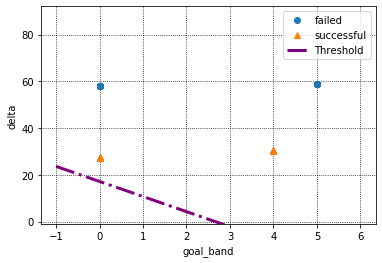

In [31]:
x1, x2 = df_ks["goal_band"].values, df_ks["delta"].values 

# データをプロット
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')

plt.plot(x1[y], x2[y], 'o', color='C0', label='failed')
plt.plot(x1[~y], x2[~y], '^', color='C1', label='successful')
#プロット数足りなくない？なぜ散布図でplt.plot使ってる？
print(type(x1[y]))

# 境界線をプロットして表示
# 紫：境界線
line_x = np.arange(np.min(x1) - 1, np.max(x1) + 1)
line_y = - line_x * w1 / w2 - w0 / w2
plt.plot(line_x, line_y, linestyle='-.', linewidth=3, color='purple', label='Threshold')
plt.ylim([np.min(x2) - 1, np.max(x2) + 1])
plt.legend(loc='best')

plt.xlabel("goal_band")
plt.ylabel("delta")
plt.show()


In [21]:
# ラベルを予測
y_pred = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

対数尤度 = -13.671
正答率 = 60.418%


In [22]:
# ラベルを予測
y_pred = clf.predict(X)

# 正答率を計算
accuracy =  accuracy_score(y, y_pred)
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# カテゴリ「2000万以上」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy） = 60.418%
適合率（Precision） = 60.483%
再現率（Recall） = 96.933%
F1値（F1-score） = 74.488%


In [23]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,191654,6065
正解 = successful,125218,8738
